In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import xarray as xr

import cartopy
import cartopy.crs as ccrs
import numpy.ma as ma
import matplotlib.colors as colors
from statistics import mode
import pandas as pd
from scipy import signal
from cartopy.util import add_cyclic_point
from scipy import interpolate

home_dir = '/glade/work/devond/'

import sys  
sys.path.insert(0, home_dir)

from functions import * 

crs_sp = ccrs.SouthPolarStereo(central_longitude=0)
crs_ll = ccrs.PlateCarree()

CESM masks

In [2]:
### ----- Read ICE SHEET MASK data ----- ###
mask_file = '/glade/work/devond/AIS_masks/model_masks/CESM_masks.nc'
cesm_masks = xr.open_dataset(mask_file)
cesm_masks = cesm_masks.sel(lat = slice(-90,-60))
lat = cesm_masks.lat.values
lon = cesm_masks.lon.values
lon_ugh = np.copy(lon)

cesm_ism = cesm_masks.grounded_ism.values #grounded ice sheet
cesm_area = cesm_masks.area.values #grid cell areas
cesm_ism_full = cesm_masks.full_ism.values
cesm_ism_full[cesm_ism_full==0] = np.nan
cesm_ism_full[cesm_ism_full>0] = 1
cesm_ism_full2, lon2 = add_cyclic_point(cesm_ism_full, coord=lon)

/glade/work/devond/my_npl_clone/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in greater
  del sys.path[0]


CESM2 (cmip6)

In [3]:
cesm_cmip_snow = xr.load_dataset(f'{home_dir}CESM/snow/CESM2_SNOW_hist.nc')
cesm_cmip_rain = xr.load_dataset(f'{home_dir}CESM/rain/CESM2_RAIN_hist.nc')
cesm_cmip_subl = xr.load_dataset(f'{home_dir}CESM/evap_subl/CESM2_QSOIL_ICE_hist.nc')
cesm_cmip_runoff = xr.load_dataset(f'{home_dir}CESM/runoff/CESM2_QRUNOFF_ICE_hist.nc')

cesm_cmip_smb = cesm_cmip_snow.SNOW + cesm_cmip_rain.RAIN - cesm_cmip_subl['QSOIL_ICE'] - cesm_cmip_runoff['QRUNOFF_ICE']
cesm_cmip_smb_ts = cesm_cmip_smb * cesm_ism * cesm_area #mask out non-antarctic area and convert from kg/m2/s to kg/s
cesm_cmip_smb_ts = cesm_cmip_smb_ts.groupby(cesm_cmip_smb_ts.time.dt.year).mean()*3600*24*365 #kg/s to kg/year
cesm_cmip_smb_ts = cesm_cmip_smb_ts.sum(dim = ['lat','lon'])/(10**12) #kg to Gt

cesm2_smb_map = cesm_cmip_smb.groupby(cesm_cmip_smb.time.dt.year).mean()*3600*24*365 *cesm_ism_full #kg/m2/s to kg/m2/year (mmwe/yr)
cesm2_smb_map = cesm2_smb_map.mean(dim = ['year','ensemble'])
cesm2_smb_map2, lon2 = add_cyclic_point(cesm2_smb_map, coord=lon)

/glade/work/devond/my_npl_clone/lib/python3.6/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


In [5]:
cesm_cmip_smb_ts.std(dim = 'year').mean()

<xarray.DataArray ()>
array(120.17168528)

CESM2-lens

In [4]:
cesm_lens_snow = xr.load_dataset(f'{home_dir}CESM/snow/CESM2lens_SNOW_hist.nc')
cesm_lens_rain = xr.load_dataset(f'{home_dir}CESM/rain/CESM2lens_RAIN_hist.nc')
cesm_lens_subl = xr.load_dataset(f'{home_dir}CESM/evap_subl/CESM2lens_QSOIL_ICE_hist.nc')
cesm_lens_runoff = xr.load_dataset(f'{home_dir}CESM/runoff/CESM2lens_QRUNOFF_ICE_hist.nc')

cesm_lens_smb = cesm_lens_snow.SNOW + cesm_lens_rain.RAIN - cesm_lens_subl['QSOIL_ICE'] - cesm_lens_runoff['QRUNOFF_ICE']
cesm_lens_smb = cesm_lens_smb * cesm_ism * cesm_area #mask out non-antarctic area and convert from kg/m2/s to kg/s
cesm_lens_smb = cesm_lens_smb.groupby(cesm_lens_smb.time.dt.year).mean()*3600*24*365 #kg/s to kg/year
cesm_lens_smb = cesm_lens_smb.sum(dim = ['lat','lon'])/(10**12) #kg to Gt

/glade/work/devond/my_npl_clone/lib/python3.6/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


CESM1-LENS

In [6]:
cesm1_snow = xr.load_dataset(f'{home_dir}CESM/snow/CESM1lens_SNOW_hist.nc')
cesm1_rain = xr.load_dataset(f'{home_dir}CESM/rain/CESM1lens_RAIN_hist.nc')
cesm1_subl = xr.load_dataset(f'{home_dir}CESM/evap_subl/CESM1lens_QSOIL_hist.nc')
cesm1_runoff = xr.load_dataset(f'{home_dir}CESM/runoff/CESM1lens_QRUNOFF_hist.nc')

cesm1_smb = cesm1_snow.SNOW + cesm1_rain.RAIN - cesm1_subl['QSOIL'] - cesm1_runoff['QRUNOFF']
cesm1_smb = cesm1_smb * cesm_ism * cesm_area #mask out non-antarctic area and convert from kg/m2/s to kg/s
cesm1_smb = cesm1_smb.groupby(cesm1_smb.time.dt.year).mean()*3600*24*365 #kg/s to kg/year
cesm1_smb = cesm1_smb.sum(dim = ['lat','lon'])/(10**12) #kg to Gt

/glade/work/devond/my_npl_clone/lib/python3.6/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


In [7]:
cesm1_smb.std(dim = 'year').mean()

<xarray.DataArray ()>
array(98.99320856)

ERA 5

In [6]:
### ----- Read ICE SHEET MASK data ----- ###
mask_file = '/glade/work/devond/AIS_masks/model_masks/ERA_masks.nc'
era_masks = xr.open_dataset(mask_file)
era_masks = era_masks.sel(lat = slice(-40,-90))

era_ism = era_masks.grounded_ism.values #grounded ice sheet
era_area = era_masks.area.values #grid cell areas

### ----- Read SMB data ----- ###
data = xr.open_dataset('/glade/work/devond/ERA5/all.nc')
ERA_SMB = (data['tp'] + data['e'])*era_ism*(10**3)*data.time.dt.days_in_month #mwe to mmwe = kg/m2 
ERA_SMB = ERA_SMB.groupby(ERA_SMB.time.dt.year).sum() #kg/m2/day to kg/m2/year
ERA_gt = ((ERA_SMB * era_area)/(10**12)).sum(dim = ['latitude', 'longitude']) #convert to gt

RACMO

In [7]:
### ----- Read ICE SHEET MASK data ----- ###
mask_file = '/glade/work/devond/AIS_masks/model_masks/RACMO_masks.nc'
racmo_masks = xr.open_dataset(mask_file)

racmo_ism = racmo_masks.grounded_ism.values #grounded ice sheet
racmo_area = racmo_masks.area.values #grid cell areas

### ----- Read RACMO data ----- ###
racmo = xr.open_dataset('/glade/work/devond/RACMO/RACMO2.3p2_ANT27_smb_monthly_1979_2016.nc')
racmo_smb = racmo.isel(height=0)['smb']#.sel(time = slice('1979-01-01', '2000-01-01')),    kg/m2/yr
racmo_smb = (((racmo_smb.groupby(racmo_smb.time.dt.year).sum())*racmo_area*racmo_ism)/(10**12)).sum(dim = ['rlat', 'rlon'])

/glade/work/devond/my_npl_clone/lib/python3.6/site-packages/xarray/core/common.py:672: FutureWarning: This DataArray contains multi-dimensional coordinates. In the future, the dimension order of these coordinates will be restored as well unless you specify restore_coord_dims=False.
  self, group, squeeze=squeeze, restore_coord_dims=restore_coord_dims


MAR

In [8]:
mar_mask = xr.open_dataset('/glade/work/devond/MAR/MARcst-AN35km-176x148.cdf')
mar_grounded = mar_mask.GROUND.values/100

In [9]:
### ----- Read MAR data ----- ###
mar = xr.open_dataset('/glade/work/devond/MAR/year-MAR_ERA5-1979-2019_zen.nc2').SMB
mar = mar.isel(SECTOR1_1=0)
mar_area_cell = 35*1000*35*1000 #m2 area of MAR gridcell
mar_area = np.zeros((mar.Y.shape[0], mar.X.shape[0]))
mar_area[mar_area==0] = mar_area_cell
mar_smb = (mar*mar_area*mar_grounded/(10**12)).sum(dim = ['X','Y'])

MERRA/MEDLEY reconstruction

In [10]:
merra_file1 = xr.open_dataset('/glade/work/devond/MERRA/acc_recon_MERRA2.nc') #kg/m2/yr
merra_area = merra_file1['area'].sel(regions = [29,30,31]).sum(dim = 'regions')

merra = xr.open_dataset('/glade/work/devond/MERRA/MERRA2_edit.nc')
merra = merra.sel(year = slice(1950,2000))
merra_gt = ((merra * merra_area)/(10**12)).sum(dim = ['lat', 'lon'])

In [15]:
#regrid merra to CESM
cesm2_smb_map_flip = convert_lon(cesm2_smb_map)
lat_old = merra['lat']
lon_old = merra['lon']
X1, Y1 = np.meshgrid(lon_old, lat_old)

lat_new = cesm2_smb_map_flip['lat']
lon_new = cesm2_smb_map_flip['lon']
X2, Y2 = np.meshgrid(lon_new, lat_new)

old_data = merra.mean(dim = 'year').smb.values
old_data[np.isnan(old_data)]=0

new_grid=interpolate.griddata((X1.flatten(),Y1.flatten()),old_data.flatten() , (X2,Y2),method='cubic')
bias = cesm2_smb_map_flip.values - new_grid
cesm_masks2 = convert_lon(cesm_masks)
cesm_grounded = cesm_masks2.grounded_ism.values
cesm_grounded[cesm_grounded > 0]=1
bias = bias*cesm_grounded
relative_bias = (bias/cesm2_smb_map_flip.values)*100
relative_bias, lon3 = add_cyclic_point(relative_bias, coord = lon_new)

/glade/work/devond/my_npl_clone/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in greater


/glade/work/devond/my_npl_clone/lib/python3.6/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


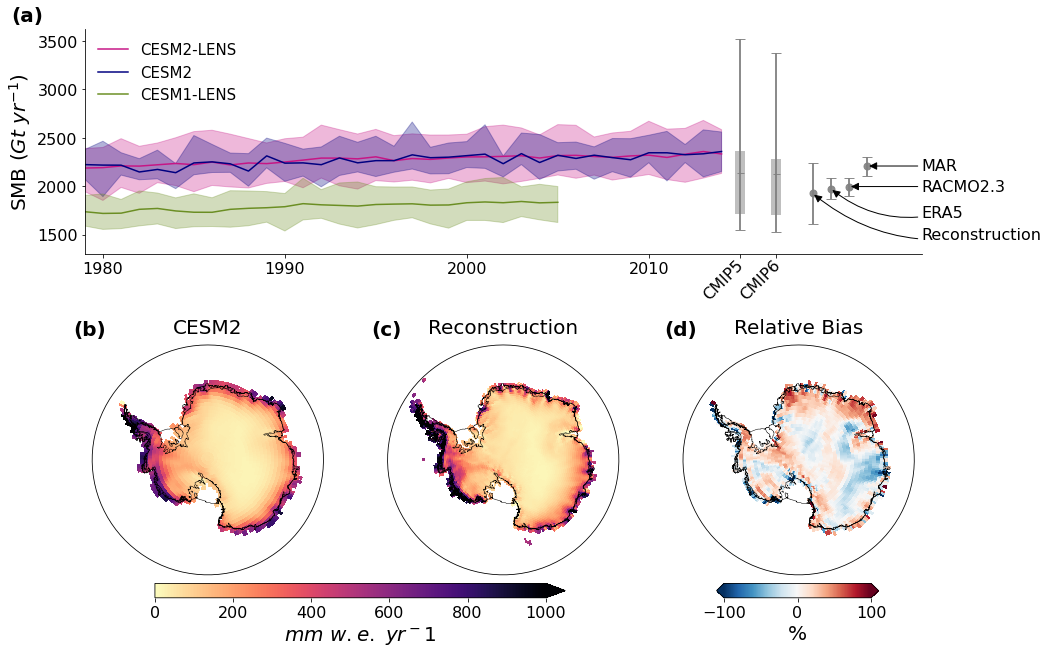

In [18]:
fig = plt.figure(figsize = (15, 10))
gs=GridSpec(7,3)
plt.rcParams['axes.titlepad'] =14

ax1 = plt.subplot(gs[0:3,0:3])
#CESM2
ax1.plot(cesm_lens_smb.year, cesm_lens_smb.mean(dim = 'ensemble'), color = 'mediumvioletred', label = 'CESM2-LENS')
ax1.fill_between(cesm_lens_smb.year, cesm_lens_smb.min(dim = 'ensemble'), cesm_lens_smb.max(dim = 'ensemble'), color = 'mediumvioletred', alpha = 0.3)
ax1.plot(cesm_cmip_smb_ts.year, cesm_cmip_smb_ts.mean(dim = 'ensemble'), color = 'navy', label = 'CESM2')
ax1.fill_between(cesm_cmip_smb_ts.year, cesm_cmip_smb_ts.min(dim = 'ensemble'), cesm_cmip_smb_ts.max(dim = 'ensemble'), color = 'navy', alpha = 0.3)

#CESM1
ax1.plot(cesm1_smb.year, cesm1_smb.mean(dim = 'ensemble'), color = 'olivedrab', label = 'CESM1-LENS')
ax1.fill_between(cesm1_smb.year, cesm1_smb.min(dim = ['ensemble']), cesm1_smb.max(dim = ['ensemble']),color = 'olivedrab', alpha = 0.3)

#MERRA
ax1.errorbar([2019], [merra_gt.mean()['smb']],yerr=[merra_gt.mean()['smb_error']], marker = 'o', markersize = 7, color = 'grey',elinewidth = 2, ecolor = 'grey', capsize = 5, alpha = 0.9)
ax1.annotate('Reconstruction', xy=(2019, merra_gt.mean()['smb']), xytext=(2025, 1500),textcoords = 'data',ha='left', va='center',fontsize = 16,
            arrowprops=dict(arrowstyle='-|>', connectionstyle='arc3,rad = -0.24', color='black'))

#CMIP5 and 6
ax1.errorbar([2015], [2140.1],yerr=[[588.87], [3517.28-2140.1]], marker = '_', markersize = 7, color = 'grey',elinewidth = 2, ecolor = 'grey', capsize = 5, alpha = 0.9)
ax1.plot([2015, 2015], [1769.9,2312.45], color='grey', linewidth = 10, alpha = 0.5)
ax1.text(0.79, -0.01, 'CMIP5', transform=ax1.transAxes, fontsize=16, rotation = 45, va='top', ha='right')
ax1.errorbar([2017], [2126.57],yerr=[[2126.57-1524.64], [3378.06-2126.57]], marker = '_', markersize = 7,color='grey',elinewidth = 2, ecolor = 'grey', capsize = 5, alpha = 0.9)
ax1.plot([2017, 2017], [1753.63,2230.03], color='grey', linewidth = 10, alpha = 0.5)
ax1.text(0.835, -0.01, 'CMIP6', transform=ax1.transAxes, fontsize=16, rotation = 45, va='top', ha='right')

#ERA-5
ax1.errorbar([2020], [ERA_gt.mean()], yerr=[ERA_gt.std()], marker = 'o', markersize = 7, color = 'grey',elinewidth = 2, ecolor = 'grey', capsize = 5, alpha = 0.9)
ax1.annotate('ERA5', xy=(2020, ERA_gt.mean()), xytext=(2025, ERA_gt.mean()-250),textcoords = 'data',ha='left', va='center',fontsize = 16,
            arrowprops=dict(arrowstyle='-|>', connectionstyle='arc3,rad = -0.25', color='black'))

#RACMO
ax1.errorbar([2021], [racmo_smb.mean()], yerr=[racmo_smb.std()], marker = 'o', markersize = 7, color = 'grey',elinewidth = 2, ecolor = 'grey', capsize = 5, alpha = 0.9)
ax1.annotate('RACMO2.3', xy=(2021, racmo_smb.mean()), xytext=(2025, racmo_smb.mean()),textcoords = 'data',ha='left', va='center',fontsize = 16,
            arrowprops=dict(arrowstyle='-|>', connectionstyle='arc3', color='black'))

#MAR
ax1.errorbar([2022], [mar_smb.mean()], yerr=[mar_smb.std()], marker = 'o', markersize = 7, color = 'grey',elinewidth = 2, ecolor = 'grey', capsize = 5, alpha = 0.9)
ax1.annotate('MAR', xy=(2022, mar_smb.mean()), xytext=(2025, mar_smb.mean()),textcoords = 'data',ha='left', va='center',fontsize = 16,
            arrowprops=dict(arrowstyle='-|>', connectionstyle='arc3', color='black'))

ax1.set_xlim([1979, 2025])
ax1.set_xticks([1980,1990,2000,2010,2015,2017]);
ax1.set_xticklabels(['1980','1990','2000','2010','',''], fontsize = 16);
ax1.set_yticks([1500,2000,2500,3000,3500]);
ax1.set_yticklabels(['1500','2000','2500','3000','3500'], fontsize = 16);
ax1.legend(frameon = False,prop={'size': 15})
ax1.set_ylabel('SMB ($Gt~yr^{-1}$)', fontsize = 20)
ax1.spines["right"].set_visible(False)
ax1.spines["top"].set_visible(False)
ax1.text(-0.05, 1.1, '(a)', transform=ax1.transAxes, fontsize=20, fontweight='bold', va='top', ha='right')


ax2 = plt.subplot(gs[4:,0],projection=crs_sp)
plot_antarctica(ax2,-60)
im2 = ax2.pcolormesh(lon2, lat, cesm2_smb_map2,transform = crs_ll, cmap = 'magma_r',vmin = 0, vmax = 1000)
ax2.set_title('CESM2', fontsize = 20)
ax2.text(0.05, 1.12, '(b)', transform=ax2.transAxes, fontsize=20, fontweight='bold', va='top', ha='right')

ax3 = plt.subplot(gs[4:,1],projection=crs_sp)
plot_antarctica(ax3,-60)
im3 = ax3.pcolormesh(merra['lon'], merra['lat'], merra['smb'].mean(dim = ['year']),transform = crs_ll, cmap = 'magma_r', vmin = 0, vmax = 1000)
ax3.set_title('Reconstruction', fontsize = 20)
ax3.text(0.05, 1.12, '(c)', transform=ax3.transAxes, fontsize=20, fontweight='bold', va='top', ha='right')

ax4 = plt.subplot(gs[4:,2],projection=crs_sp)
plot_antarctica(ax4,-60)
im4 = ax4.pcolormesh(lon3, lat, relative_bias ,transform = crs_ll, cmap = 'RdBu_r', vmin = -100, vmax = 100)
ax4.set_title('Relative Bias', fontsize = 20)
ax4.text(0.05, 1.12, '(d)', transform=ax4.transAxes, fontsize=20, fontweight='bold', va='top', ha='right')

    #fig.subplots_adjust(bottom=0.01)
cbar_ax = fig.add_axes([0.19, 0.09, 0.38, 0.02])
cb = fig.colorbar(im2, cax=cbar_ax, orientation = 'horizontal', extend = 'max')
cb.set_label(label=f'$mm~w.e.~yr^{-1}$', size=20)
cb.ax.tick_params(labelsize=16)

cbar_ax = fig.add_axes([0.71, 0.09, 0.15, 0.02])
cb = fig.colorbar(im4, cax=cbar_ax, orientation = 'horizontal', extend = 'both')
cb.set_label(label=f'%', size=20)
cb.ax.tick_params(labelsize=16)

plt.savefig('smb.png', dpi = 300, bbox_inches = 'tight', transparent = True)


Compare significance of means

In [19]:
def calc_t_stat(mean1, mean2, std1, std2, n1, n2):
    t = (mean1 - mean2)/np.sqrt(std1**2/n1 + std2**2/n2)
    df = np.min([n1, n2])-1
    return t, df

In [20]:
merra_temp = merra_gt.sel(year = slice(1979,2015))
cesm2_temp = cesm_cmip_smb_ts.sel(year = slice(1979,2015))
cesm2_lens_temp = cesm_lens_smb.sel(year = slice(1979,2015))

t_merra, merra_df= calc_t_stat(merra_temp['smb'].mean(), cesm2_temp.mean(), merra_temp['smb_error'].mean(), cesm2_temp.std(), len(merra_temp.year), len(cesm2_temp.year))
t_lens, lens_df= calc_t_stat(cesm2_lens_temp.mean(), cesm2_temp.mean(), cesm2_lens_temp.std(), cesm2_temp.std(), len(cesm2_lens_temp.year), len(cesm2_temp.year))
t_era5, era5_df= calc_t_stat(ERA_gt.mean(), cesm2_temp.mean(), ERA_gt.std(), cesm2_temp.std(), len(ERA_gt.year), len(cesm2_temp.year))
t_racmo, racmo_df= calc_t_stat(racmo_smb.mean(), cesm2_temp.mean(), racmo_smb.std(), cesm2_temp.std(), len(racmo_smb.year), len(cesm2_temp.year))
t_mar, mar_df= calc_t_stat(mar_smb.mean(), cesm2_temp.mean(), mar_smb.std(), cesm2_temp.std(), len(mar_smb.TIME), len(cesm2_temp.year))


In [21]:
for i in range(11):
    ensemble = cesm2_temp.isel(ensemble=i)
    t,df = calc_t_stat(racmo_smb.mean(), ensemble.mean(), racmo_smb.std(), ensemble.std(), len(racmo_smb.year), len(ensemble.year))
    if i == 0:
        print(df)
    if t < -2.030:
        print(t.values)

35
-11.84865548930345
-9.576328916844101
-10.179730753287174
-10.340657610722433
-11.534723295225895
-11.142981834874908
-10.342250348294266
-12.745499498229618
-11.713227018439985
-12.660746013529698
-11.480582681053109


Trend significance & Break point analysis

In [25]:
bp_year = get_bp_year(cesm_cmip_smb_ts.mean(dim = 'ensemble'),30)

before = cesm_cmip_smb_ts.mean(dim = 'ensemble').sel(year = slice(1850, bp_year))
trend_before = linregress(before.year.values, before.values)
line_before = trend_before.slope*before.year.values + trend_before.intercept

after = cesm_cmip_smb_ts.mean(dim = 'ensemble').sel(year = slice(bp_year,2015))
trend_after = linregress(after.year.values, after.values)
line_after = trend_after.slope*after.year.values + trend_after.intercept

print(trend_before)
print(trend_after)

LinregressResult(slope=0.5272359682565134, intercept=1104.8548010486363, rvalue=0.5350008812119834, pvalue=2.1790400372131094e-10, stderr=0.0760046720563695)
LinregressResult(slope=4.689243994278563, intercept=-7094.380667920426, rvalue=0.8547714189116284, pvalue=1.5470473034069103e-13, stderr=0.4393386772307365)


In [26]:
cesm1_smbxx = cesm1_smb.sel(year = slice(1971, 2005)).mean(dim = 'ensemble')
cesm1_trend = linregress(cesm1_smbxx.year.values, cesm1_smbxx.values)
cesm1_trend

LinregressResult(slope=4.326021664249776, intercept=-6827.126707637335, rvalue=0.9506969985669482, pvalue=2.4020532713374073e-18, stderr=0.24565249785798274)

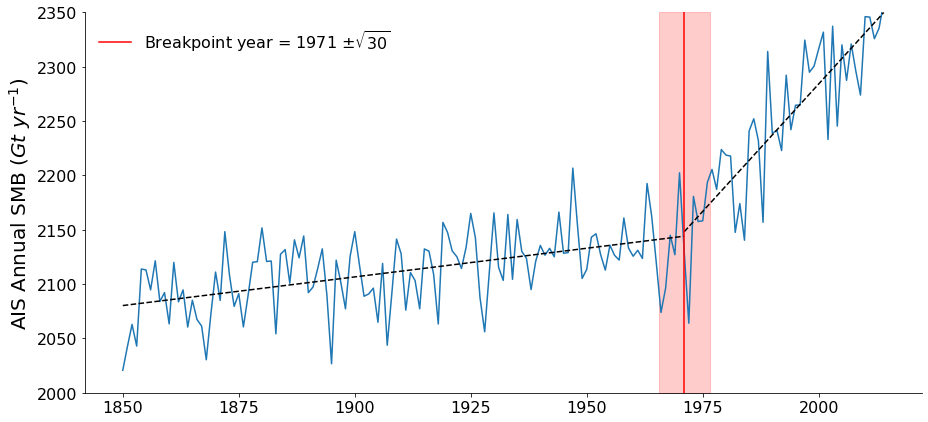

In [29]:
fig, ax = plt.subplots(1,1,figsize = (15,7))
ax.plot(cesm_cmip_smb_ts.year, cesm_cmip_smb_ts.mean(dim = 'ensemble'))
ax.plot(before.year, line_before, 'k--')
ax.plot(after.year, line_after, 'k--')
ax.plot([bp_year, bp_year],[2000,2350], 'r', label = 'Breakpoint year = 1971 $\pm \sqrt{30}$ ')
ax.fill_between([bp_year-np.sqrt(30), bp_year+np.sqrt(30)], [2000,2000], [2350,2350], color = 'red', alpha = 0.2)
ax.set_ylim([2000,2350])
ax.legend(frameon = False,prop={'size': 16})
ax.set_ylabel('AIS Annual SMB ($Gt~yr^{-1}$)', fontsize = 20)
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.tick_params(labelsize=16)
plt.savefig('smb_breakpoint_year.png', dpi = 300, bbox_inches = 'tight')



In [117]:
era_trend = linregress(ERA_gt.year, ERA_gt)
print('ERA: ', era_trend)
racmo_trend = linregress(racmo_smb.year, racmo_smb)
print('RACMO: ', racmo_trend)
mar_trend = linregress(mar_smb.TIME.dt.year, mar_smb)
print('MAR: ', mar_trend)
merra_gt_1971 = merra_gt.sel(year = slice(1971, 2000)).smb
merra_trend = linregress(merra_gt_1971.year, merra_gt_1971)
print('MERRA: ', merra_trend)

ERA:  LinregressResult(slope=-1.5087031937431865, intercept=4989.470418675715, rvalue=-0.1694533118450609, pvalue=0.28952737516695404, stderr=1.4050601429272924)
RACMO:  LinregressResult(slope=-0.5063012009537451, intercept=3008.59458275047, rvalue=-0.05996719930130476, pvalue=0.720615620903051, stderr=1.4046290887334836)
MAR:  LinregressResult(slope=-0.4260808675691675, intercept=3060.9184190761566, rvalue=-0.051404804556427076, pvalue=0.7495874865046523, stderr=1.32550526327385)
MERRA:  LinregressResult(slope=0.3982460742900748, intercept=1149.730193871757, rvalue=0.05803096987741733, pvalue=0.7606711435677099, stderr=1.2947328319924087)


## SMB Maps

In [4]:
### ----- Read SMB data ----- ###
rain = xr.open_dataset('/glade/work/devond/CESM/rain/CESM2_RAIN_hist.nc')['RAIN']
snow = xr.open_dataset('/glade/work/devond/CESM/snow/CESM2_SNOW_hist.nc')['SNOW']
evap = xr.open_dataset('/glade/work/devond/CESM/evap_subl/CESM2_QSOIL_ICE_hist.nc')['QSOIL_ICE']
runoff = xr.open_dataset('/glade/work/devond/CESM/runoff/CESM2_QRUNOFF_ICE_hist.nc')['QRUNOFF_ICE']

cesm_ism_full = cesm_masks.full_ism.values
cesm_ism_full[cesm_ism_full==0] = np.nan
cesm_ism_full[cesm_ism_full>0] = 1

lat = cesm_masks.lat.values
lon = cesm_masks.lon.values
cesm_ism_full2, lon2 = add_cyclic_point(cesm_ism_full, coord=lon)

cesm2_smb = rain + snow - evap - runoff
cesm2_smb = cesm2_smb.sel(time = slice('1979-01-01','2015-01-01'))
cesm2_smb = cesm2_smb.groupby(cesm2_smb.time.dt.year).mean()*3600*24*365 *cesm_ism_full #kg/m2/s to kg/m2/year (mmwe/yr)
cesm2_map = cesm2_smb.mean(dim = ['year','ensemble'])
cesm2_map2, lon2 = add_cyclic_point(cesm2_map, coord=lon)

/glade/work/devond/my_npl_clone/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in greater
  if __name__ == '__main__':
/glade/work/devond/my_npl_clone/lib/python3.6/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


In [5]:
merra2 = merra.sel(year = slice(1979,2015))

In [18]:
#regrid merra to CESM

cesm2_smb2 = convert_lon(cesm2_smb)
lat_old = merra2['lat']
lon_old = merra2['lon']
X1, Y1 = np.meshgrid(lon_old, lat_old)

lat_new = cesm2_smb2['lat']
lon_new = cesm2_smb2['lon']
X2, Y2 = np.meshgrid(lon_new, lat_new)

old_data = merra2.mean(dim = 'year').smb.values
old_data[np.isnan(old_data)]=0

new_grid=interpolate.griddata((X1.flatten(),Y1.flatten()),old_data.flatten() , (X2,Y2),method='cubic')
bias = cesm2_smb2.mean(dim = ['year', 'ensemble']).values - new_grid
cesm_masks2 = convert_lon(cesm_masks)
cesm_grounded = cesm_masks2.grounded_ism.values
cesm_grounded[cesm_grounded > 0]=1
bias = bias*cesm_grounded
relative_bias = (bias/cesm2_smb2.mean(dim = ['year', 'ensemble']).values)*100

/glade/work/devond/my_npl_clone/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in greater


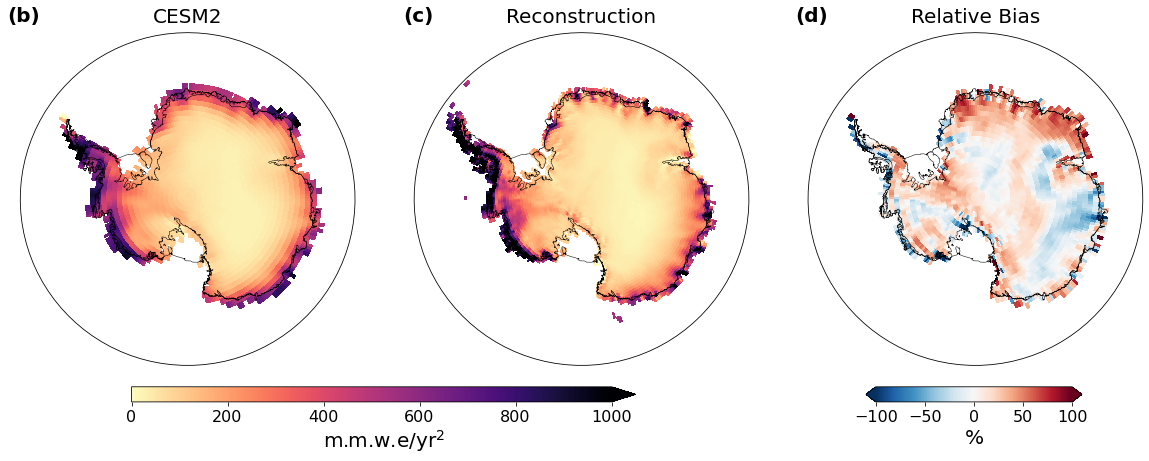

In [19]:
fig = plt.figure(figsize = (20,7))
gs=GridSpec(1,3)
plt.rcParams['axes.titlepad'] =14

ax1 = plt.subplot(gs[0],projection=crs_sp)
plot_antarctica(ax1,-60)
im = ax1.pcolormesh(lon2, lat, cesm2_map,transform = crs_ll, cmap = 'magma_r',vmin = 0, vmax = 1000)
ax1.set_title('CESM2', fontsize = 20)
ax1.text(0.05, 1.09, '(b)', transform=ax1.transAxes, fontsize=20, fontweight='bold', va='top', ha='right')

ax2 = plt.subplot(gs[1],projection=crs_sp)
plot_antarctica(ax2,-60)
im = ax2.pcolormesh(merra2['lon'], merra2['lat'], merra2['smb'].mean(dim = ['year']),transform = crs_ll, cmap = 'magma_r', vmin = 0, vmax = 1000)
ax2.set_title('Reconstruction', fontsize = 20)
ax2.text(0.05, 1.09, '(c)', transform=ax2.transAxes, fontsize=20, fontweight='bold', va='top', ha='right')

ax3 = plt.subplot(gs[2],projection=crs_sp)
plot_antarctica(ax3,-60)
im2 = ax3.pcolormesh(cesm2_smb2['lon'], cesm2_smb2['lat'], relative_bias ,transform = crs_ll, cmap = 'RdBu_r', vmin = -100, vmax = 100)
ax3.set_title('Relative Bias', fontsize = 20)
ax3.text(0.05, 1.09, '(d)', transform=ax3.transAxes, fontsize=20, fontweight='bold', va='top', ha='right')

    #fig.subplots_adjust(bottom=0.01)
cbar_ax = fig.add_axes([0.2, 0.1, 0.35, 0.03])
cb = fig.colorbar(im, cax=cbar_ax, orientation = 'horizontal', extend = 'max')
cb.set_label(label=f'm.m.w.e/yr$^2$', size=20)
cb.ax.tick_params(labelsize=16)

cbar_ax = fig.add_axes([0.71, 0.1, 0.15, 0.03])
cb = fig.colorbar(im2, cax=cbar_ax, orientation = 'horizontal', extend = 'both')
cb.set_label(label=f'%', size=20)
cb.ax.tick_params(labelsize=16)

plt.savefig('smb_maps.png', dpi = 300, bbox_inches = 'tight')

## SMB numbers by region


In [23]:
east = cesm_masks.east.values*cesm_masks.grounded_ism.values
west = cesm_masks.west.values*cesm_masks.grounded_ism.values
pen = cesm_masks.peninsula.values*cesm_masks.grounded_ism.values

east_area = np.nansum(east*cesm_area)
west_area = np.nansum(west*cesm_area)
pen_area = np.nansum(pen*cesm_area)

In [28]:
### ----- Read SMB data ----- ###
rain = xr.open_dataset('/glade/work/devond/CESM/rain/CESM2_RAIN_hist.nc')['RAIN']
snow = xr.open_dataset('/glade/work/devond/CESM/snow/CESM2_SNOW_hist.nc')['SNOW']
evap = xr.open_dataset('/glade/work/devond/CESM/evap_subl/CESM2_QSOIL_ICE_hist.nc')['QSOIL_ICE']
runoff = xr.open_dataset('/glade/work/devond/CESM/runoff/CESM2_QRUNOFF_ICE_hist.nc')['QRUNOFF_ICE']

cesm2_smb = rain + snow - evap - runoff
cesm2_smb = cesm2_smb.sel(time = slice('1979-01-01','2015-01-01'))
cesm2_smb = cesm2_smb.groupby(cesm2_smb.time.dt.year).mean()*3600*24*365
cesm2_map = cesm2_smb.mean(dim = ['year','ensemble'])

/glade/work/devond/my_npl_clone/lib/python3.6/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


In [44]:
cesm2_east = (cesm2_map*east).mean()
cesm2_west = (cesm2_map*west).mean()
cesm2_pen = (cesm2_map*pen).mean()

cesm east = <xarray.DataArray ()>
array(104.95475138)
cesm east = <xarray.DataArray ()>
array(303.38025632)
cesm east = <xarray.DataArray ()>
array(571.85984186)


In [36]:
merra2 = merra.sel(year = slice(1979,2015))

In [37]:
#regrid merra to CESM
cesm2_smb2 = convert_lon(cesm2_smb)
lat_old = merra2['lat']
lon_old = merra2['lon']
X1, Y1 = np.meshgrid(lon_old, lat_old)

lat_new = cesm2_smb2['lat']
lon_new = cesm2_smb2['lon']
X2, Y2 = np.meshgrid(lon_new, lat_new)

old_data = merra2.mean(dim = 'year').smb.values
old_data[np.isnan(old_data)]=0

new_grid=interpolate.griddata((X1.flatten(),Y1.flatten()),old_data.flatten() , (X2,Y2),method='cubic')
bias = cesm2_smb2.mean(dim = ['year', 'ensemble']).values - new_grid
cesm_masks2 = convert_lon(cesm_masks)
cesm_grounded = cesm_masks2.grounded_ism.values
cesm_grounded[cesm_grounded > 0]=1
bias = bias*cesm_grounded
relative_bias = (bias/cesm2_smb2.mean(dim = ['year', 'ensemble']).values)*100

/glade/work/devond/my_npl_clone/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in greater


## Queen Maud Land

In [55]:
basin4 = xr.open_dataset('/glade/work/devond/AIS_masks/basin_masks/AIS_Fullbasins_Zwally_CESMgrid_basin4.nc')
basin5 = xr.open_dataset('/glade/work/devond/AIS_masks/basin_masks/AIS_Fullbasins_Zwally_CESMgrid_basin5.nc')
basin6 = xr.open_dataset('/glade/work/devond/AIS_masks/basin_masks/AIS_Fullbasins_Zwally_CESMgrid_basin6.nc')
basin7 = xr.open_dataset('/glade/work/devond/AIS_masks/basin_masks/AIS_Fullbasins_Zwally_CESMgrid_basin7.nc')
basin8 = xr.open_dataset('/glade/work/devond/AIS_masks/basin_masks/AIS_Fullbasins_Zwally_CESMgrid_basin8.nc')

In [79]:
QML = (basin4+basin5+basin6+basin7+basin8)['Zwallybasins']
QML = QML.sel(lat = slice(-90,-60))
QML = convert_lon(QML)
lon_convert = QML.lon
QML = QML.values
QML[QML == 0] = np.nan

In [80]:
bias_qml = bias*QML
np.nansum(bias_qml*cesm_area)/10**12

In [103]:
relative_qml = np.sum(relative_bias*QML*cesm_area)/np.nansum(cesm_area*QML)
np.nanmean(relative_qml)

/glade/work/devond/my_npl_clone/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: Mean of empty slice
  


nan

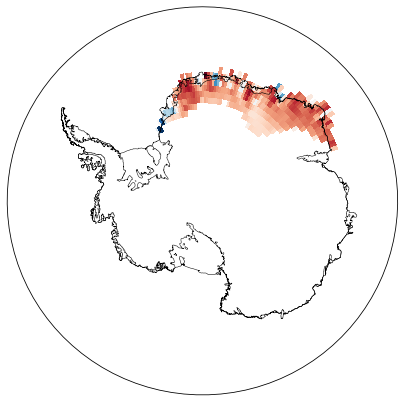

In [101]:
fig = plt.figure(figsize = (7,7))
gs=GridSpec(1,1)
plt.rcParams['axes.titlepad'] =14

ax1 = plt.subplot(gs[0],projection=crs_sp)
plot_antarctica(ax1,-60)
im = ax1.pcolormesh(lon_convert, lat, relative_qml,transform = crs_ll, cmap = 'RdBu_r',vmin = -100, vmax = 100)
